You should me more organized. You are still learning though

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [9]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

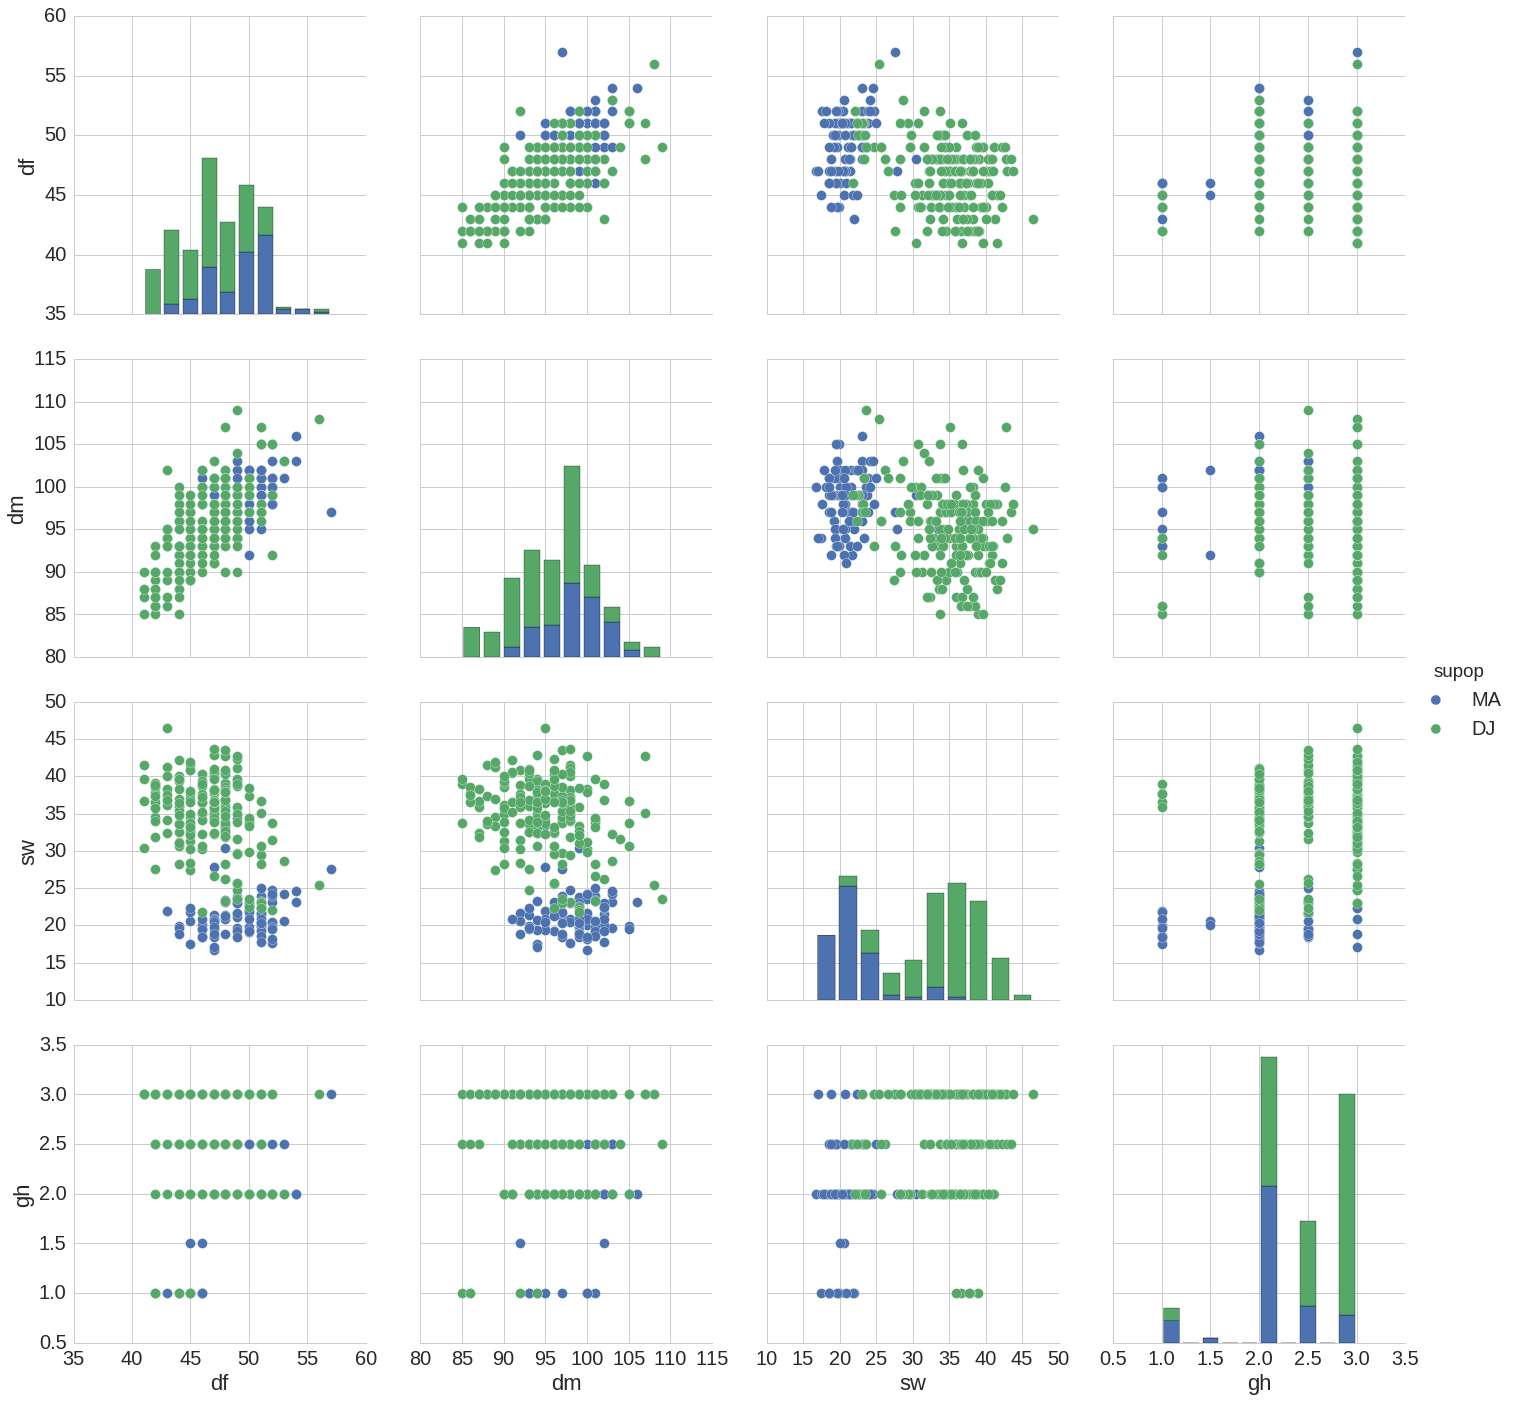

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [6]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RandomizedLogisticRegression

## Feature selection approach

In [7]:
def select_features(X,y):
    selector = RandomizedLogisticRegression(n_resampling=500, 
                                            random_state=101, 
                                            selection_threshold=0.001)
    selector.fit(X,y)
    return(selector.transform(X))

## Stratify byclass

## Early 25%

In [14]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = select_features(X_train, y_train)

classification_prescreen_early = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                           cv = 5, jobs=7)

Processing SGD model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing linearSVC model 5 of 9
Processing KNeighbors model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing MLP model 9 of 9


## Late 25

In [15]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

X_train_s = select_features(X_train, y_train)

classification_prescreen_late = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                          cv = 5, jobs=7)

Processing SGD model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing linearSVC model 5 of 9
Processing KNeighbors model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing MLP model 9 of 9


## 3 classes

In [16]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

X_train_s = select_features(X_train, y_train)

classification_prescreen_all = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                         cv = 5, jobs=7)

Processing SGD model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing linearSVC model 5 of 9
Processing KNeighbors model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing MLP model 9 of 9


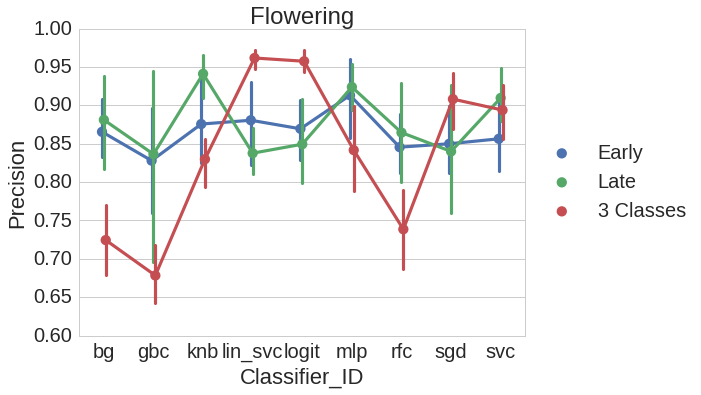

In [18]:
# plot both
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
two_class = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])

sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = two_class, dodge=True)
plt.ylabel('Precision')
plt.title('Flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

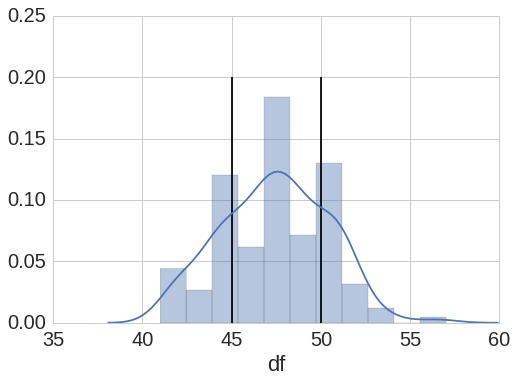

In [48]:
sns.distplot(df)
plt.vlines(np.percentile(df, 25), 0, .20)
plt.vlines(np.percentile(df, 75), 0, .20);

It seems that the best performance is achieved for 3 classes
I will start with two classes and the following algorithms using **precision_macro**:

1. linear_SVC

2. Logit



# Prepare data-3 classes

Prepare data

In [19]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

X_train_s = select_features(X_train, y_train)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(precision_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)

## Logit 

In [20]:
from sklearn.linear_model import LogisticRegression

lg_default = LogisticRegression(random_state=42)
y_pred = report_res(lg_default, X_train_s, y_train, 'macro')

0.937566137566
             precision    recall  f1-score   support

          0       0.90      0.92      0.91        62
          1       0.94      0.97      0.95       122
          2       0.97      0.85      0.91        40

avg / total       0.93      0.93      0.93       224



In [50]:
param_grid = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 3, 10),
             'solver':['liblinear', 'saga'], 'class_weight': [None, 'balanced']}

lg = LogisticRegression(random_state=42, n_jobs=6)

lg_search_param = GridSearchCV(lg,param_grid=param_grid,
                                   scoring='precision_macro',n_jobs=6,iid=False,
                                   cv=5)
lg_search_param.fit(X_train_s, y_train)
print(lg_search_param.best_params_)
print(lg_search_param.best_estimator_)

y_pred=report_res(lg_search_param, X_train_s, y_train, 'macro')

{'penalty': 'l1', 'solver': 'liblinear', 'C': 10000.0, 'class_weight': 'balanced'}
LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=6, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


KeyboardInterrupt: 

other param grid
{'penalty': 'l1', 'solver': 'liblinear', 'C': 10000.0, 'class_weight': 'balanced'}
LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=6, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Logit Precision Matrix', fontsize=26)
plt.show()